# Titanic Survival Data Review
This is a competition from Kaggle with the goal of predicting survival on the titanic. Training of your machine learning algorithm is to be performed on the `train.csv` test set, and then predictions are to be submitted based on the `test.csv` test set.

This notebook focuses only on examining the data. For predictions, please see `titanic_predictions.ipynb`.

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

plt.style.use('fivethirtyeight')

# five_thirty_eight = [
#     "#30a2da",
#     "#fc4f30",
#     "#e5ae38",
#     "#6d904f",
#     "#8b8b8b",
# ]
#sns.set_style('five_thirty_eight')

In [51]:
data = pd.read_csv('./data/train.csv')

## Data Review

In [52]:
data.shape

(891, 12)

VARIABLE DESCRIPTIONS:

```survival        Survival
                (0 = No; 1 = Yes)
pclass          Passenger Class
                (1 = 1st; 2 = 2nd; 3 = 3rd)
name            Name
sex             Sex
age             Age
sibsp           Number of Siblings/Spouses Aboard
parch           Number of Parents/Children Aboard
ticket          Ticket Number
fare            Passenger Fare
cabin           Cabin
embarked        Port of Embarkation
                (C = Cherbourg; Q = Queenstown; S = Southampton)
```


SPECIAL NOTES:
Pclass is a proxy for socio-economic status (SES)
 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower

Age is in Years; Fractional if Age less than One (1)
 If the Age is Estimated, it is in the form xx.5

With respect to the family relation variables (i.e. sibsp and parch)
some relations were ignored.  The following are the definitions used
for sibsp and parch.

- Sibling:  Brother, Sister, Stepbrother, or Stepsister of Passenger Aboard Titanic
- Spouse:   Husband or Wife of Passenger Aboard Titanic (Mistresses and Fiances Ignored)
- Parent:   Mother or Father of Passenger Aboard Titanic
- Child:    Son, Daughter, Stepson, or Stepdaughter of Passenger Aboard Titanic

Other family relatives excluded from this study include cousins, nephews/nieces, aunts/uncles, and in-laws.  Some children travelled only with a nanny, therefore parch=0 for them.  As well, some travelled with very close friends or neighbors in a village, however, the definitions do not support such relations.

In [53]:
data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [54]:
#convert names to lowercase just to make it easier to type.
data.columns = map(str.lower, data.columns)

In [55]:
data.dtypes

passengerid      int64
survived         int64
pclass           int64
name            object
sex             object
age            float64
sibsp            int64
parch            int64
ticket          object
fare           float64
cabin           object
embarked        object
dtype: object

Let's split up the dataset into survived and died:

In [56]:
survived = data[data.survived==1]
died = data[~data.index.isin(survived.index)]

Let's look to see which columns have mising values. We will need to decide if we drop cases with missing values or if we fill them in with median values.

In [57]:
data.isnull().sum()

passengerid      0
survived         0
pclass           0
name             0
sex              0
age            177
sibsp            0
parch            0
ticket           0
fare             0
cabin          687
embarked         2
dtype: int64

It looks like we will need to fill in missing values for age. It looks like a majority of passengers don't have cabins. Maybe we will classify based on if they had a cabin or not.

### Gender

Let's create a category based on sex and age, ie: Man, Woman, Child.

In [58]:
def find_man_woman_child(row):
    if row.age < 16:
        return "child"
    else:
        return row.sex

data['who'] = data.apply(find_man_woman_child,axis=1)

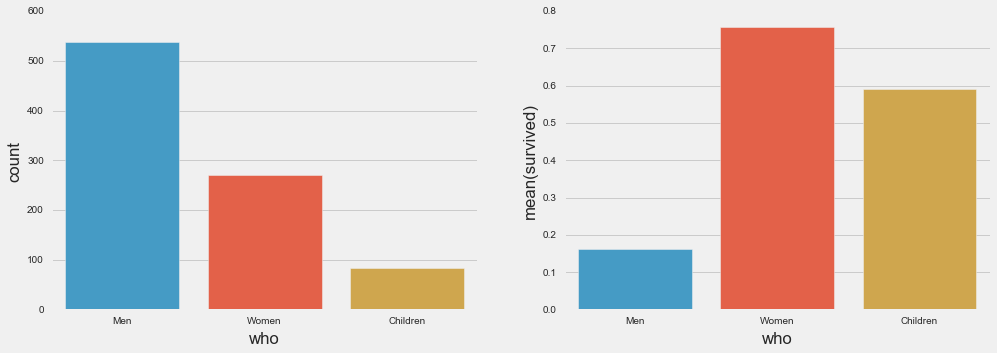

In [59]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
g = sns.countplot(x='who',data=data,ax=ax1)
g.set_xticklabels(["Men","Women","Children"])
g = sns.barplot(x='who',y='survived',data=data,ax=ax2,ci=None)
g.set_xticklabels(["Men","Women","Children"])
plt.show()

### Age
Let's look at age how age affects survival:

/Users/kyletabor/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


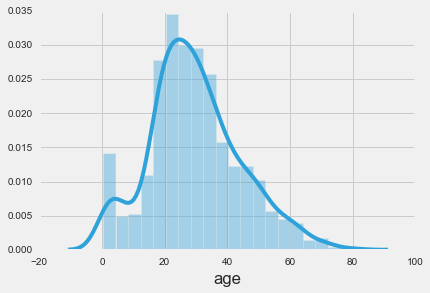

In [60]:
sns.distplot(data.age.dropna())

How many age values are null?

In [61]:
#check for missing values
data.age.isnull().sum()

177

Let's fill in the null values with the median age values:

In [62]:
data.age.fillna(data.age.median(),inplace=True)
data.age.isnull().sum()

0

/Users/kyletabor/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


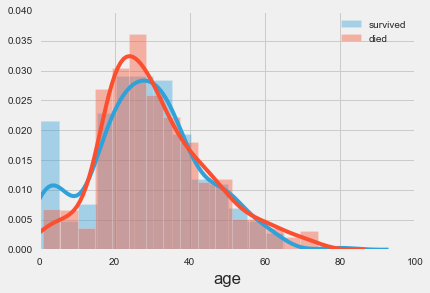

In [63]:
fig, ax = plt.subplots()
sns.distplot(survived.age.dropna(), ax=ax, kde=True, label='survived')
sns.distplot(died.age.dropna(), ax=ax, kde=True, label='died')
ax.set_xlim([0, 100])
plt.legend()

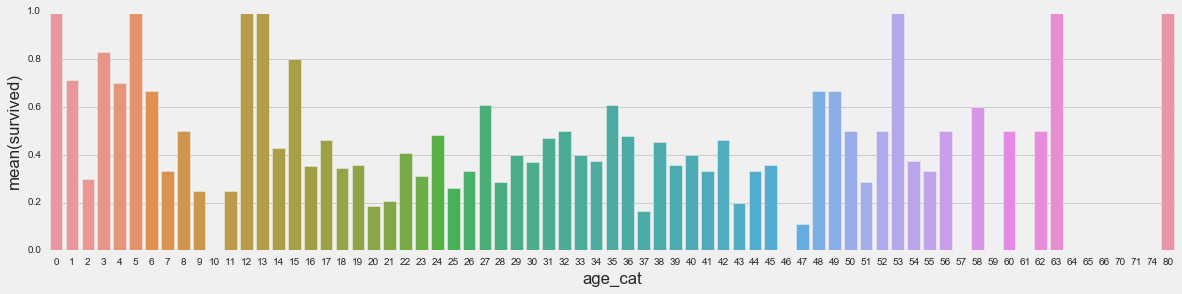

In [64]:
fig, ax1 = plt.subplots(1,1,figsize=(18,4))
data['age_cat'] = data.age.astype(int)
average_age = data.groupby(['age_cat'],as_index=False).mean()
g = sns.barplot(x='age_cat', y='survived', data=average_age,ax = ax1)
plt.show()

### Passenger Class
Let's look at how survival varies by class.

In [65]:
# first check for missing values
data.pclass.value_counts(dropna=False)

3    491
1    216
2    184
Name: pclass, dtype: int64

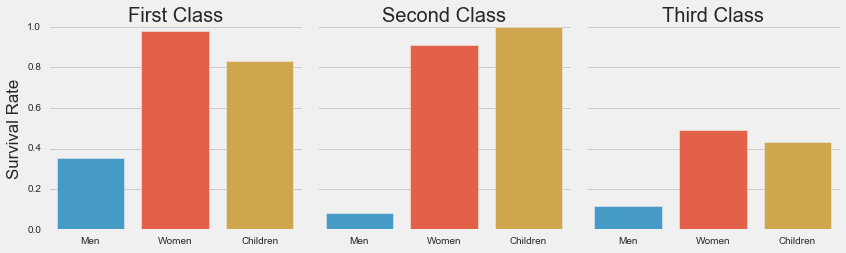

In [66]:
g = sns.factorplot(x='who',y='survived',col = 'pclass',data=data,size=4,aspect=1,kind='bar',ci=None)
g.set_xticklabels(['Men','Women','Children'])
g.set_axis_labels("",'Survival Rate')
titles = ["First Class", "Second Class", "Third Class"]
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

### Embarkation Location
Survival by where they embarked

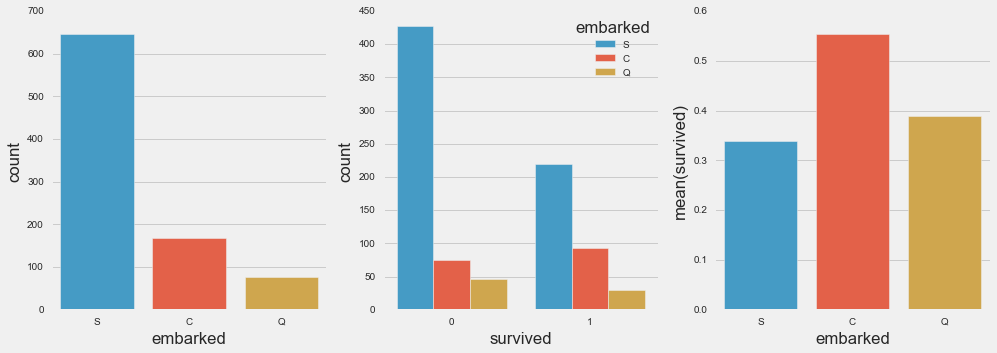

In [119]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))
sns.countplot(x='embarked', data=data, ax=ax1, order=['S','C','Q'])

sns.countplot(x='survived', hue='embarked',data=data,ax=ax2)

embark_perc = data[["embarked", "survived"]].groupby('embarked',as_index=False).agg('mean')
sns.barplot(x='embarked', y='survived', data=embark_perc,order=['S','C','Q'],ax=ax3)

Since we have some mising values for embarked, let's fill in null values with the most common value

In [68]:
data.embarked.fillna(data.embarked.mode()[0],inplace=True)
data.embarked.isnull().sum()

0

So it looks like passengers who boarded in Cherbourg have a much higher survival rate than those from Queenstown or Southampton.

### Fare / Ticket Price

How does fare vary by class?

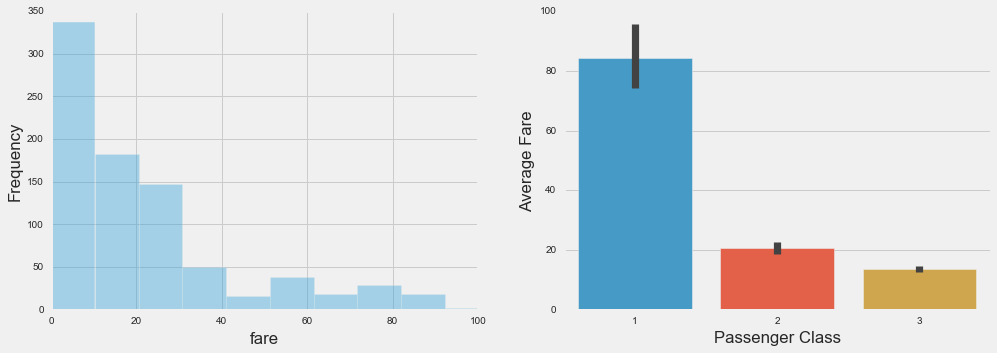

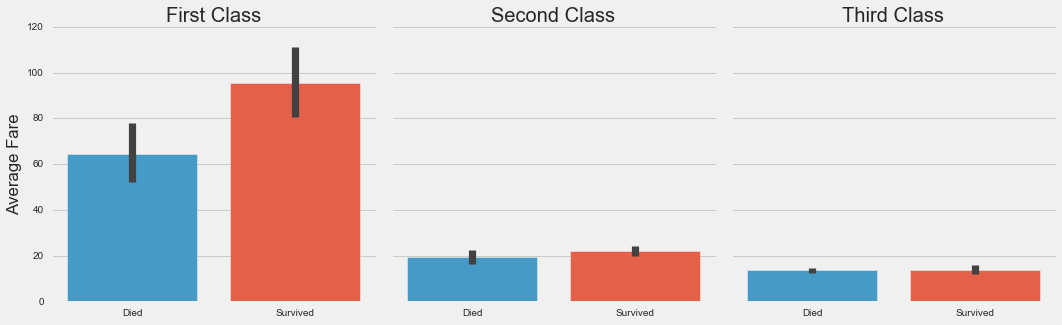

In [69]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
g = sns.distplot(data.fare,ax=ax1,kde=False)
g.set_ylabel('Frequency')
g.set_xlim([0, 100])


group = data.groupby('pclass',as_index=False).agg('mean')
g = sns.barplot(x='pclass',y='fare',data=data, ax=ax2)
g.set_xlabel('Passenger Class')
g.set_ylabel('Average Fare')
plt.show()

g = sns.factorplot(x='survived',y='fare',col='pclass',data=data,kind='bar',size=5, aspect=1)
g.set_xticklabels(['Died','Survived'])
g.set_axis_labels("","Average Fare")
titles = ["First Class", "Second Class", "Third Class"]
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)
plt.show()

Wow, there is a big difference in fares between classes.

### Cabin Type

In [70]:
data.cabin.value_counts(dropna=False).head(10)

NaN            687
G6               4
B96 B98          4
C23 C25 C27      4
C22 C26          3
F33              3
F2               3
E101             3
D                3
C78              2
Name: cabin, dtype: int64

According to https://en.wikipedia.org/wiki/RMS_Titanic, there are 10 different decks, and only 7 (A, B, C, D, E, F, G) were used for passenger accomodations. Let's strip out the letter from the cabin number and assigned it as its own variable.

In [71]:
#lets convert the n/a values to "N" so we can know if they had a cabin or not.
data.cabin = data.cabin.fillna('N')

In [72]:
def find_deck(cabin):
    if len(cabin) > 0:
        deck = str(cabin)[0]
        return deck
    
data['deck'] = data.cabin.apply(lambda x: find_deck(x))

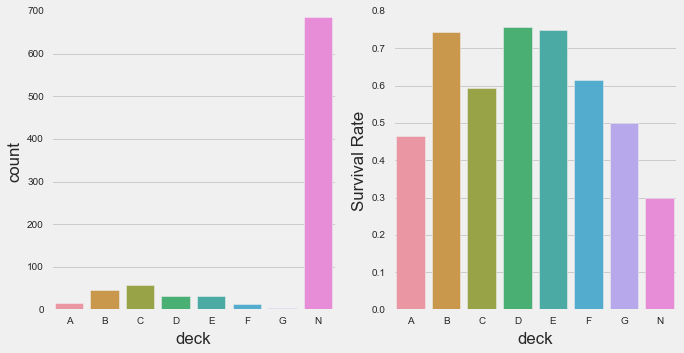

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
g = sns.countplot(x='deck', data=data, ax=ax1, order=['A','B','C','D','E','F','G','N'])
g = sns.barplot(x='deck', y='survived', data=data, ci=None, order=['A','B','C','D','E','F','G','N'], ax=ax2)
g.set_ylabel('Survival Rate')
plt.show()

So it looks like there is definitely a better chance for survival if they passengers had a cabin.

Let's clean up the mapping to just the decks we know about. I'm not sure what's happening with the `T` value, but let's just assume it's not a cabin.

In [74]:
data.deck = pd.Series([x  if (x in ['A','B','C','D','E','F','G']) else None for x in data.deck])

In [75]:
data['has_cabin'] = [1 if x else 0 for x in ~data.deck.isnull()]
data.has_cabin.value_counts()

0    688
1    203
Name: has_cabin, dtype: int64

I wonder how many people have cabins based on the class?

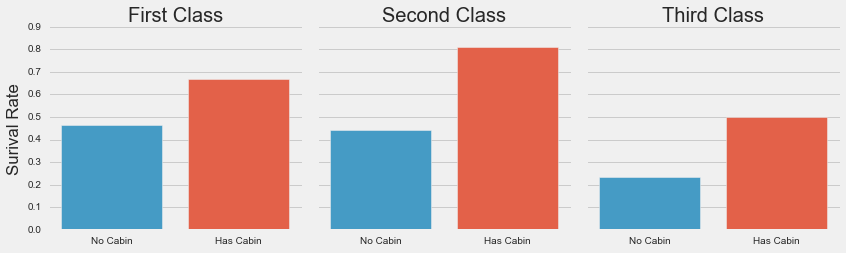

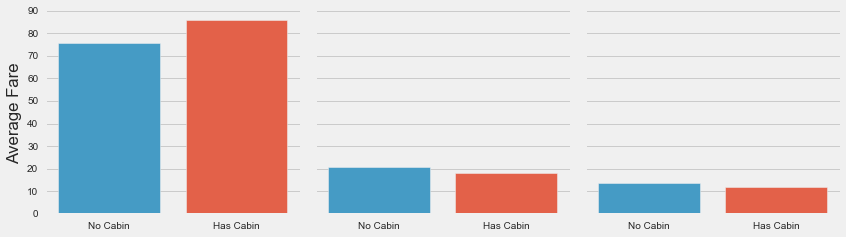

In [102]:

g = sns.factorplot(x='has_cabin',y='survived',col='pclass',data=data,ci=None,kind='bar',order=[0,1])
g.set_xticklabels(['No Cabin','Has Cabin'])
g.set_axis_labels('',"Surival Rate")
titles = ["First Class", "Second Class", "Third Class"]
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)
g = sns.factorplot(x='has_cabin',y='fare',col='pclass',data=data,ci=None,kind='bar',order=[0,1])
g.set_xticklabels(['No Cabin','Has Cabin'])
g.set_axis_labels('',"Average Fare")
g.set_titles("")

### Ticket Numbers
Let's look at the ticket variable. How many unique ticket values are there?

In [125]:
data.ticket.describe()

count          891
unique         681
top       CA. 2343
freq             7
Name: ticket, dtype: object

In [126]:
data.ticket.unique()[:10]

array(['A/5 21171', 'PC 17599', 'STON/O2. 3101282', '113803', '373450',
       '330877', '17463', '349909', '347742', '237736'], dtype=object)

Wow there are a lot of values. Let's see if we can remove the numbers and spaces and see if there are any commonalities.

In [137]:
data['ticket_prefix'] = data.ticket.apply(lambda x: re.sub('[^A-Za-z]+', '', x))
data.ticket_prefix.value_counts()

             661
PC            60
CA            41
A             28
STONO         18
SOTONOQ       15
WC            10
SCPARIS        7
SOC            6
FCC            5
C              5
LINE           4
SCParis        4
WEP            3
PP             3
SOPP           3
SWPP           2
SCAH           2
PPP            2
SOTONO         2
SC             1
AS             1
FC             1
SP             1
SCA            1
SOP            1
Fa             1
SCAHBasle      1
CASOTON        1
SCOW           1
Name: ticket_prefix, dtype: int64

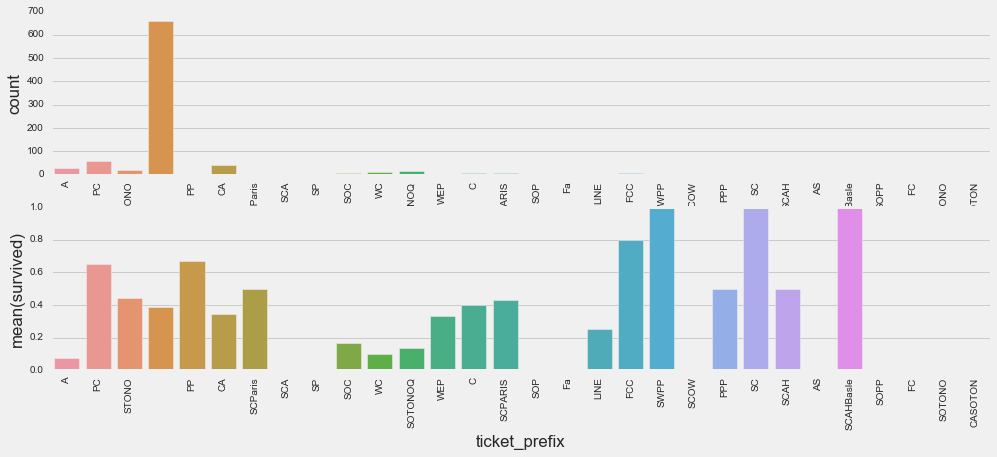

In [219]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(15,6))
g = sns.countplot(x='ticket_prefix',data=data,ax=ax1)
labels = g.get_xticklabels()
g.set_xticklabels(labels, rotation='vertical')
g = sns.barplot(x='ticket_prefix',y='survived',data=data,ci=None,ax=ax2)
labels = g.get_xticklabels()
g.set_xticklabels(labels, rotation='vertical')
plt.show()

I wonder if having a ticket prefix matters for survival?

In [139]:
def has_prefix(string):
    if re.search('[A-Za-z]+',string) is not None:
        return 1
    else:
        return 0
    
data['has_prefix'] = data.ticket.apply(has_prefix)

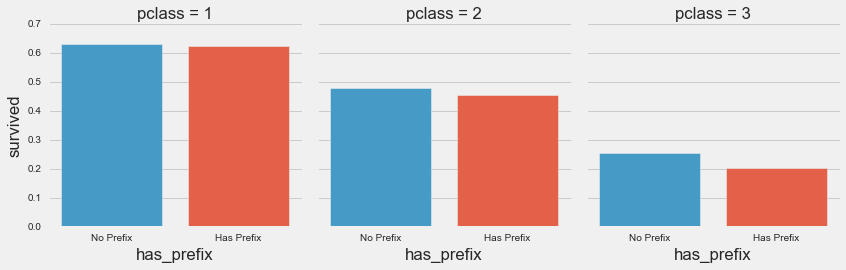

In [140]:
g = sns.factorplot(x='has_prefix',y='survived',col='pclass',data=data,kind='bar',ci=None)
g.set_xticklabels(['No Prefix','Has Prefix'])

So it looks like having a ticket prefix doesn't matter.

What if the length of the number matters?

In [82]:
data['ticket_number'] = data.ticket.apply(lambda x: re.sub('[^0-9]+', "", x))
data.ticket_number = pd.to_numeric(data.ticket_number)

In [83]:
data[['ticket_number','survived']].corr()

,ticket_number,survived
ticket_number,1.000000,-0.015921
survived,-0.015921,1.000000


Darn. All that work and it looks like the ticket doesn't realy matter.

### Family Members
Does family matter?

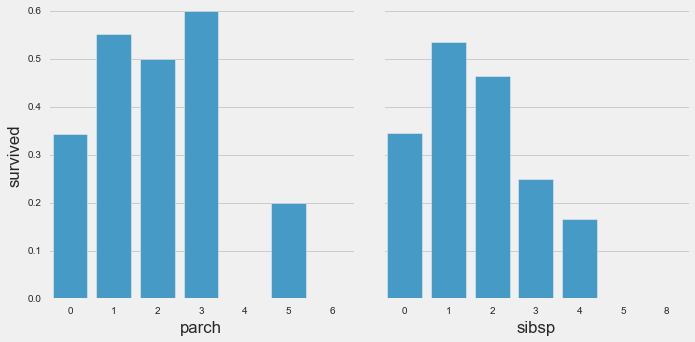

In [210]:
g = sns.PairGrid(x_vars=['parch','sibsp'],y_vars='survived',data=data,size=5)
g.map(sns.barplot,ci=None)

Let's create a new variable based on the total family size:

In [166]:
data['fam_size'] = data.sibsp + data.parch + 1

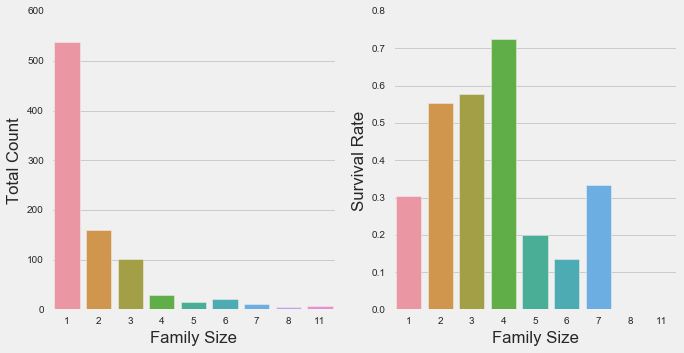

In [169]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
g = sns.countplot(x='fam_size',data=data,ax=ax1)
g.set_xlabel('Family Size')
g.set_ylabel('Total Count')
g = sns.barplot(x='fam_size',y='survived',data=data,ci=None,ax=ax2)
g.set_xlabel('Family Size')
g.set_ylabel('Survival Rate')

It looks like there is a correlation to survival rate based on the family size. There is a more than 50% chance of survival for family sizes of 2, 3, and 4 people. However, it decreases for families over 5 people.

### Name
Let's look at the name:

In [204]:
data.name.describe()

count                         891
unique                        891
top       Hedman, Mr. Oskar Arvid
freq                            1
Name: name, dtype: object

So it looks like all of the names are unique. Lets extract the title from the names:

In [197]:
def get_title(name):
    # Use a regular expression to search for a title.  
    #Titles always consist of capital and lowercase letters, and end with a period.
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

data['title'] = data.name.apply(get_title)

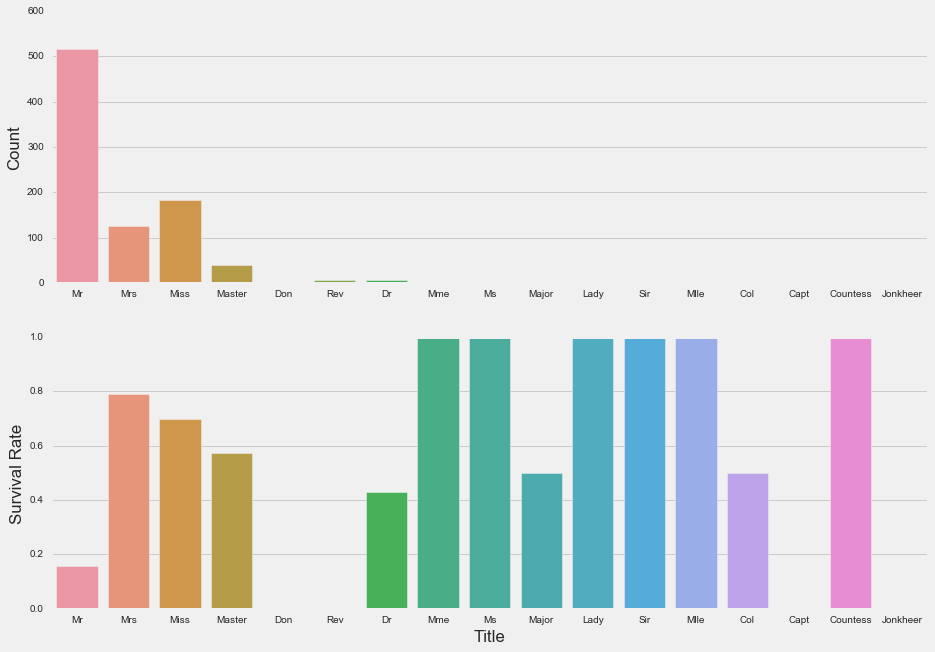

In [199]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(14,10))
g = sns.countplot(x='title',data=data,ax=ax1)
g.set_ylabel('Count')
g.set_xlabel('')
g = sns.barplot(x='title',y='survived',data=data,ci=None,ax=ax2)
g.set_ylabel('Survival Rate')
g.set_xlabel('Title')

So it looks like there are several rare titles, which have high survival rates. Let's group together some of the rare titles.

In [205]:
data.title = data.title.replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', \
                                             'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
data.title = data.title.replace('Mlle', 'Miss')
data.title = data.title.replace('Ms', 'Miss')
data.title = data.title.replace('Mme', 'Mrs')

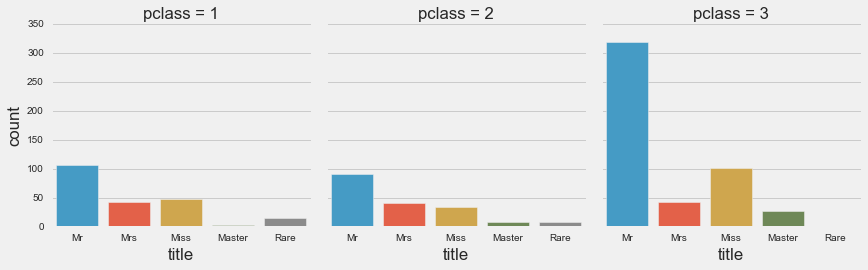

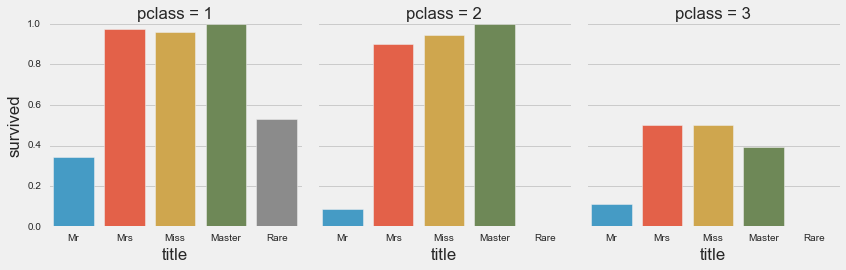

In [206]:
sns.factorplot(x='title',col='pclass',data=data,ci=None,kind='count')
sns.factorplot(x='title',y='survived',col='pclass',data=data,ci=None,kind='bar')

It looks like there are significantly more `Mr` title in third class. Overall, it looks like the survival rate is much higher for female and rare titles in first and second class.

Let's create a unique family id based on the last name and family size:

In [96]:
def find_last_name(name):
    return name.split(',')[0]
data['family_name'] = data.name.apply(find_last_name)
data.family_name.value_counts().head(10)

Andersson    9
Sage         7
Johnson      6
Panula       6
Carter       6
Goodwin      6
Skoog        6
Rice         5
Williams     4
Harris       4
Name: family_name, dtype: int64

In [97]:
def family_id(row):
    last_name = find_last_name(row['name'])
    if row['fam_size'] > 3:
        fam_id = "{0}{1}".format(last_name,row['fam_size'])
        return fam_id
    else:
        return None
data['fam_id'] = data.apply(family_id,axis=1)
data.fam_id.value_counts(dropna=False).head(10)

NaN           800
Andersson7      8
Sage11          7
Panula6         6
Goodwin8        6
Skoog6          6
Rice6           5
Palsson5        4
Ford5           4
Lefebre5        4
Name: fam_id, dtype: int64

Let's see if there is a correlation between having a family_id and survival.

In [98]:
data['has_fam_id'] = [1 if x else 0 for x in data.fam_id.isnull() ]
data[['has_fam_id','survived']].corr()

,has_fam_id,survived
has_fam_id,1.000000,0.029945
survived,0.029945,1.000000


Eh, it doesn't look like a significant correlation.